Section 1: define and train the VAE model with the MNIST data set.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
# Set the seed for the global random number generator
tf.random.set_seed(42)
random.seed(42)
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# we set the dimention of the latent variable as 2 for visualization in this assignment
latent_dim = 2

# Build the encoder
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(encoder_inputs)
x = layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(14, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(3136, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Define the VAE as a Model with a custom train_step
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# load MNIST data
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

# VAE training
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

11490434/11490434 [==============================] - 2s 0us/step
Epoch 1/30
547/547 [==============================] - 20s 9ms/step - loss: 209.8752 - reconstruction_loss: 208.0668 - kl_loss: 1.8083
Epoch 2/30
547/547 [==============================] - 4s 8ms/step - loss: 180.4219 - reconstruction_loss: 178.4286 - kl_loss: 1.9933
Epoch 3/30
547/547 [==============================] - 4s 8ms/step - loss: 162.8287 - reconstruction_loss: 159.8828 - kl_loss: 2.9459
Epoch 4/30
547/547 [==============================] - 5s 9ms/step - loss: 158.4426 - reconstruction_loss: 155.3725 - kl_loss: 3.0701
Epoch 5/30
547/547 [==============================] - 4s 8ms/step - loss: 156.2215 - reconstruction_loss: 153.0848 - kl_loss: 3.1367
Epoch 6/30
547/547 [==============================] - 5s 8ms/step - loss: 154.7940 - reconstruction_loss: 151.6135 - kl_loss: 3.1805
Epoch 7/30
547/547 [==============================] - 5s 8ms/step - loss: 153.6951 - reconstruction_loss: 150.4806 - kl_loss: 3.2145
Epo

Section 2: Display how the latent space clusters different digit classes.

1875/1875 [==============================] - 4s 2ms/step


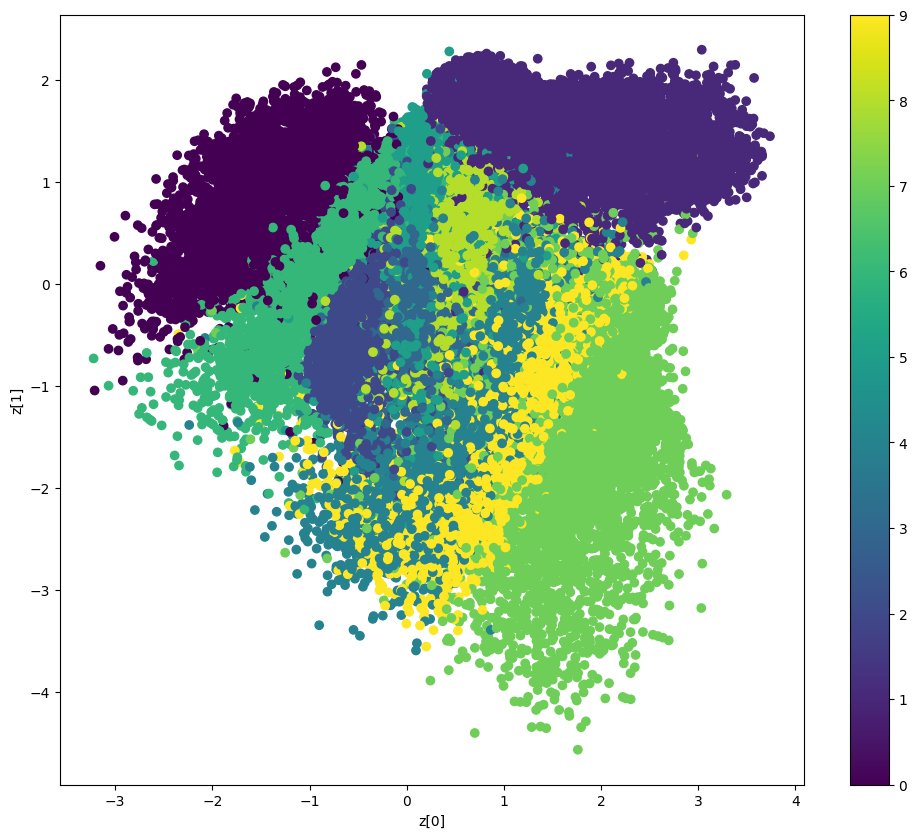

In [2]:
import matplotlib.pyplot as plt
# display a 2D plot of the digit classes in the latent space
def plot_label_clusters(encoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)

Section 3: Based on the plot onbtained in Section 2, find the appropriate regions in the 2-D plot and display a grid of sampled digit images generated by different latent variables.

1/1 [==============================] - 0s 19ms/step


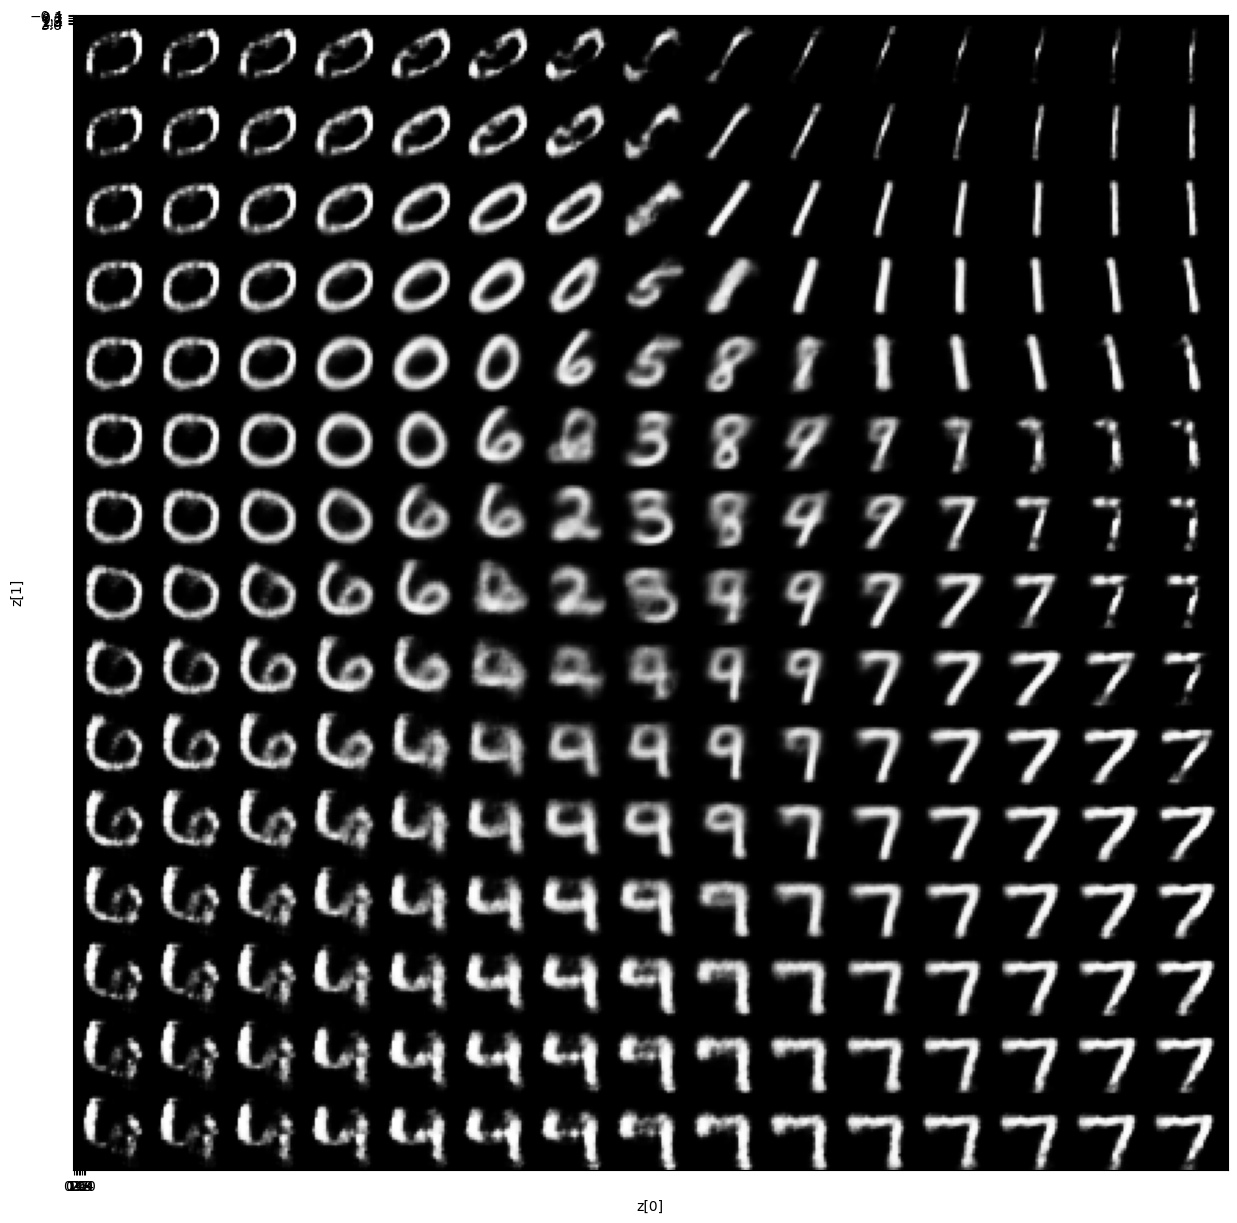

In [3]:
# please find the active regions for latent variables from above 2-D plot and set the fowlling 4 values appropriately
x_lower = -4
x_upper = 4
y_lower = -5
y_upper = 3

# Display a grid of sampled digits generated by the VAE model
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 15
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(x_lower, x_upper, n)
    grid_y = np.linspace(y_lower, y_upper, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(sample_range_x)
    plt.yticks(sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

(0,0) output:

1/1 [==============================] - 0s 126ms/step


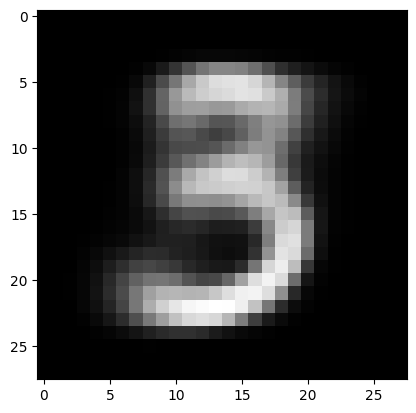

In [4]:
Latent = np.array([[0, 0]])
decoded = decoder.predict(Latent)
output = decoded[0].reshape(28, 28)
plt.imshow(output, cmap='gray')
plt.show()